# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [44]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.charge_flip_ss import charge_flip_ss
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [47]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_ucsd_mini, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = True
local = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'charge_flip_ss'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples(year)

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'top',], year, redirector=redirector_ucsd_mini, small=False)
# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

#meta = get_sample_meta(fileset, samples)

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress

    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)

    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.dask_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        charge_flip_ss(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()
    

DEBUG:logger_metis:Doing DIS query of type files for /DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM
DEBUG:logger_metis:Doing DIS query of type files for /DYJetsToLL_M-5to50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM


samples_2018.yaml


DEBUG:logger_metis:Doing DIS query of type files for /TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM


I'm running now


Preprocessing:   0%|          | 0/60 [00:00<?, ?file/s]

Processing:   0%|          | 0/730 [00:00<?, ?chunk/s]

In [48]:
output['totalEvents']['all']/1e6

174.459937

Full fileset is 174M events, and that's DY and ttbar.

In [49]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
eta_bins       = hist.Bin('eta', r'$\eta $', np.array([0, 0.8, 1.479, 2.5]))
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)
pdg_bins       = hist.Bin('pdgID', r'$pdg ID$', 26, 0, 25)


# define nicer labels and colors

nano_mappings = nano_mapping(year)


my_labels = {
    nano_mappings['TTW'][0]: 'all',
    nano_mappings['TTZ'][0]: 'ttZ',
    nano_mappings['DY'][0]: 'DY',
    nano_mappings['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mappings['TTW'][0]: '#8AC926',
    nano_mappings['TTZ'][0]: '#FFCA3A',
    nano_mappings['DY'][0]: '#6A4C93',
    nano_mappings['top'][0]: '#1982C4',
}


# 1D Histograms

In [50]:
from yahist import Hist1D, Hist2D

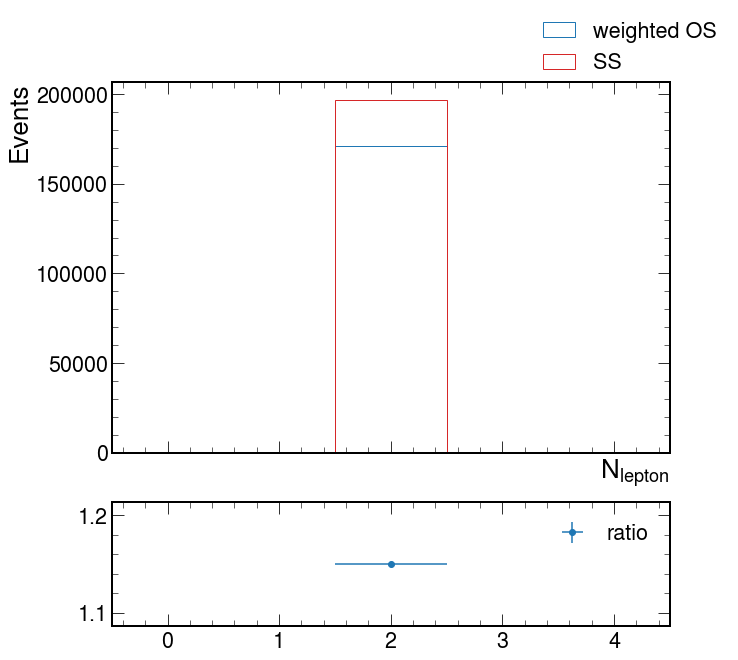

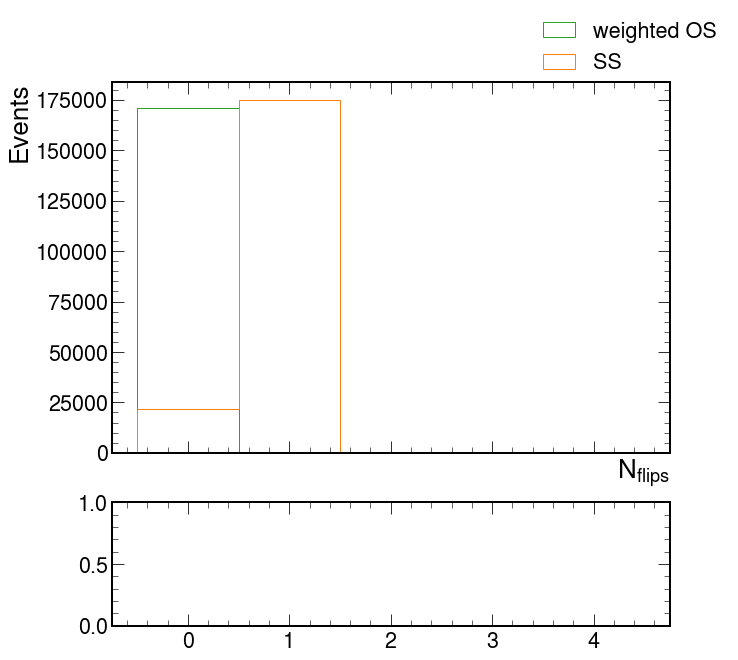

In [59]:
tmp1 = output['N_ele'].copy()
tmp1 = tmp1.rebin('multiplicity', N_bins_red)


tmp2 = output['N_ele2'].copy()
tmp2 = tmp2.rebin('multiplicity', N_bins_red)

tmp3 = output['electron_flips'].copy()
tmp3 = tmp3.rebin('multiplicity', N_bins_red)

tmp4 = output['electron_flips2'].copy()
tmp4 = tmp4.rebin('multiplicity', N_bins_red)

h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('multiplicity').edges()),
)

h2 = Hist1D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('multiplicity').edges()),
)

h3 = Hist1D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('multiplicity').edges()),
)

h4 = Hist1D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('multiplicity').edges()),
)

h1_TT = Hist1D.from_bincounts(
    tmp1.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('multiplicity').edges()),
)

h2_TT = Hist1D.from_bincounts(
    tmp2.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('multiplicity').edges()),
)

h1_DY = Hist1D.from_bincounts(
    tmp1.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('multiplicity').edges()),
)

h2_DY = Hist1D.from_bincounts(
    tmp2.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('multiplicity').edges()),
)

h3_TT = Hist1D.from_bincounts(
    tmp3.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('multiplicity').edges()),
)


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h2.plot(ax=ax1, alpha=1, color="C0")
h1.plot(ax=ax1, alpha=1, color="C3")


ax1.set_xlabel(r'$N_{lepton}\ $')
ax1.set_ylabel(r'Events')

fig.legend(["weighted OS", "SS"])

# Gaussian errors
#    (num/den).plot(ax=ax2,show_errors=True,label="ratio")
# Asymmetric Clopper-Pearson errors
h1.divide(h2, binomial=True).plot(ax=ax2, errors=True, label="ratio")



fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h4.plot(ax=ax1, alpha=1, color="C2")
h3.plot(ax=ax1, alpha=1, color="C1")


ax1.set_xlabel(r'$N_{flips}\ $')
ax1.set_ylabel(r'Events')

fig.legend(["weighted OS", "SS",])

# Gaussian errors
#    (num/den).plot(ax=ax2,show_errors=True,label="ratio")
# Asymmetric Clopper-Pearson errors

In [60]:
print(tmp3.sum('dataset').values()[()].T)
print(tmp4.sum('dataset').values()[()].T)

[ 21746.6281212 174997.509269       0.             0.
      0.       ]
[1.71084253e+05 3.79376039e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


In [52]:
tmp1 = output['electron'].copy()
tmp1 = tmp1.rebin('pt', pt_bins)
tmp1 = tmp1.rebin('eta', eta_bins)

tmp2 = output['electron2'].copy()
tmp2 = tmp2.rebin('pt', pt_bins)
tmp2 = tmp2.rebin('eta', eta_bins)

tmp3 = output['electron3'].copy()
tmp3 = tmp3.rebin('pt', pt_bins)
tmp3 = tmp3.rebin('eta', eta_bins)

tmp4 = output['electron4'].copy()
tmp4 = tmp4.rebin('pt', pt_bins)
tmp4 = tmp4.rebin('eta', eta_bins)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)

h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

h3 = Hist2D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),
)

h4 = Hist2D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),
)

h1_TT = Hist2D.from_bincounts(
    tmp1.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),)

h2_TT = Hist2D.from_bincounts(
    tmp2.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),)

h3_TT = Hist2D.from_bincounts(
    tmp3.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),)

h4_TT = Hist2D.from_bincounts(
    tmp4.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),)

h1_DY = Hist2D.from_bincounts(
    tmp1.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),)

h2_DY = Hist2D.from_bincounts(
    tmp2.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),)

h3_DY = Hist2D.from_bincounts(
    tmp3.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),)

h4_DY = Hist2D.from_bincounts(
    tmp4.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),)

<AxesSubplot:>

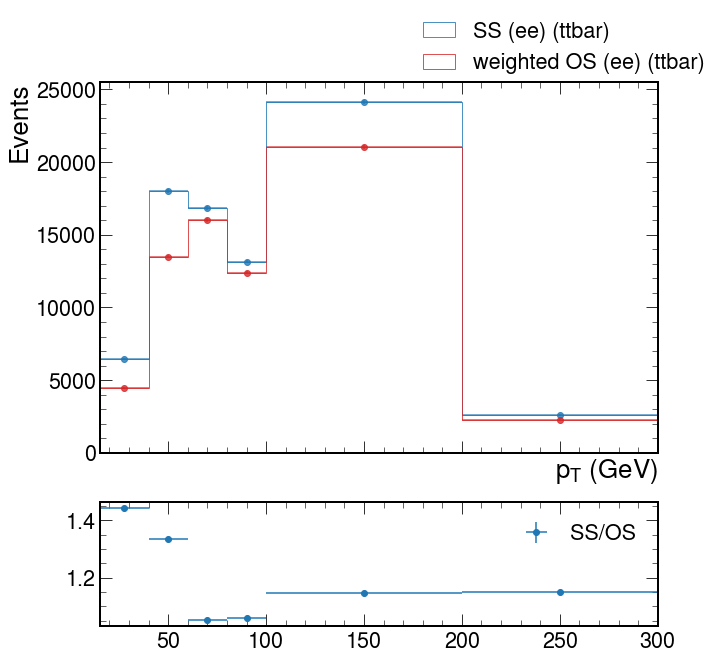

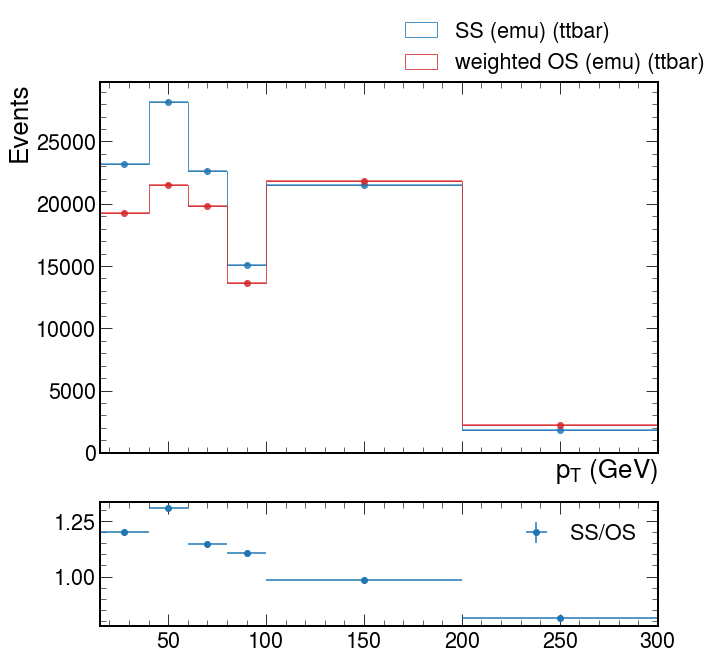

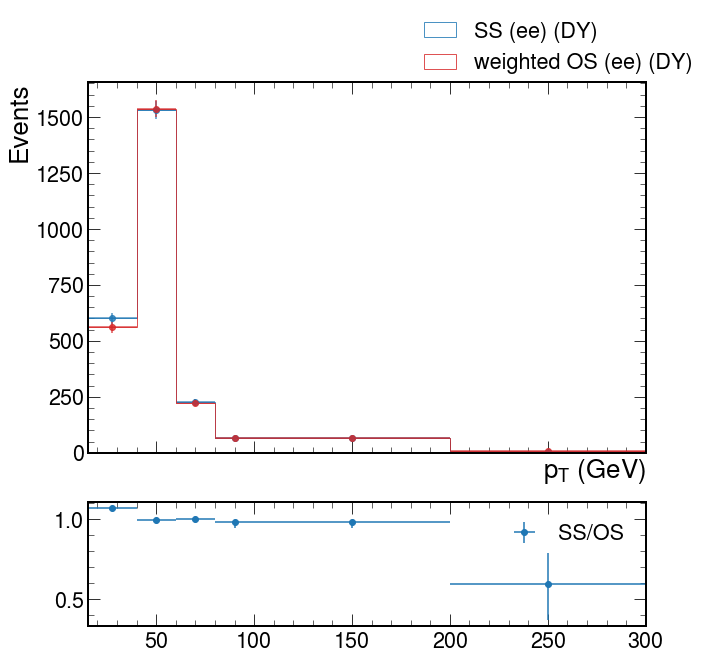

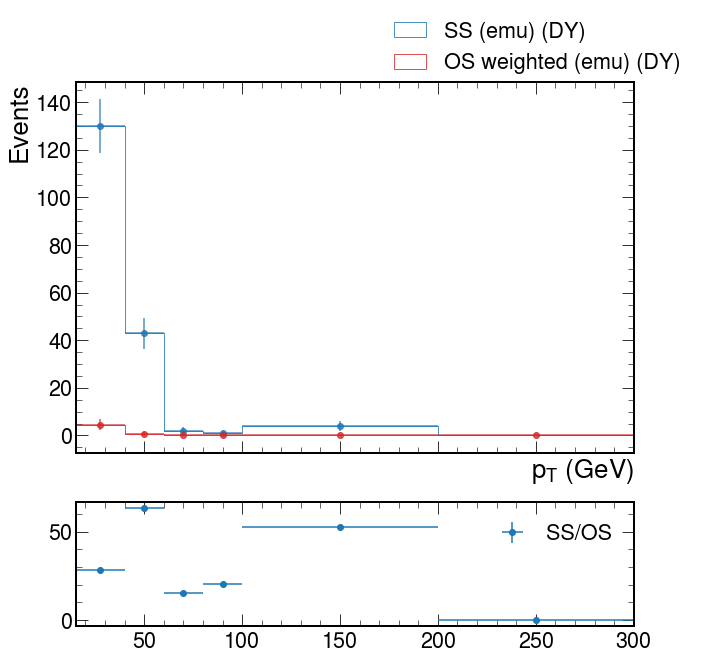

In [53]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C0")
h2_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C3")
h1_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True)
h2_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True)


fig.legend(["SS (ee) (ttbar)", "weighted OS (ee) (ttbar)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h1_TT.projection('x').divide(h2_TT.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C0")
h4_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C3")
h3_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True)
h4_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True)


fig.legend(["SS (emu) (ttbar)", "weighted OS (emu) (ttbar)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h3_TT.projection('x').divide(h4_TT.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C0")
h2_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C3")
h1_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True)
h2_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True)


fig.legend(["SS (ee) (DY)", "weighted OS (ee) (DY)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h1_DY.projection('x').divide(h2_DY.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C0")
h4_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C3")
h3_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True)
h4_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True)


fig.legend(["SS (emu) (DY)", "OS weighted (emu) (DY)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h3_DY.projection('x').divide(h4_DY.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


<AxesSubplot:>

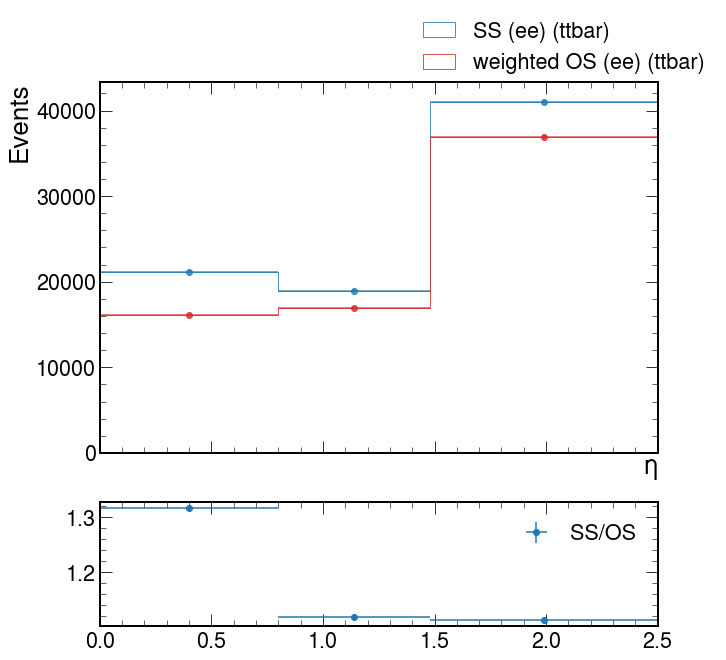

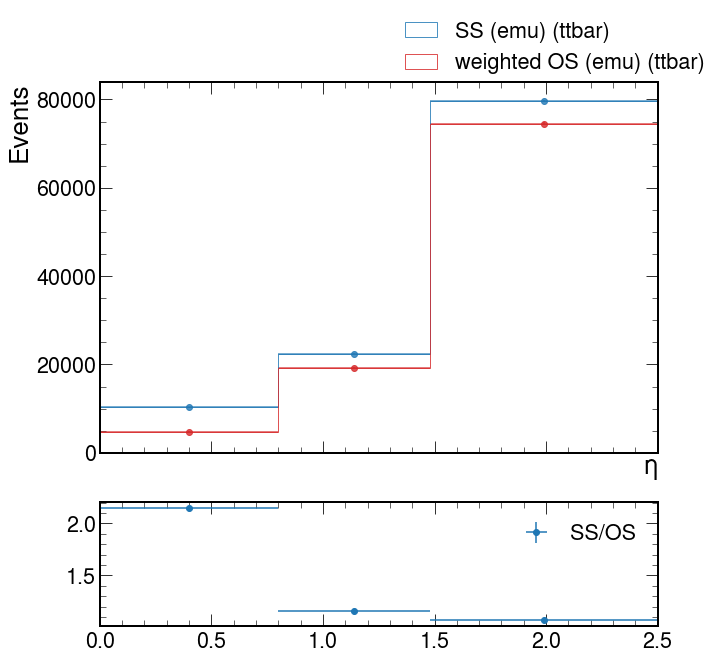

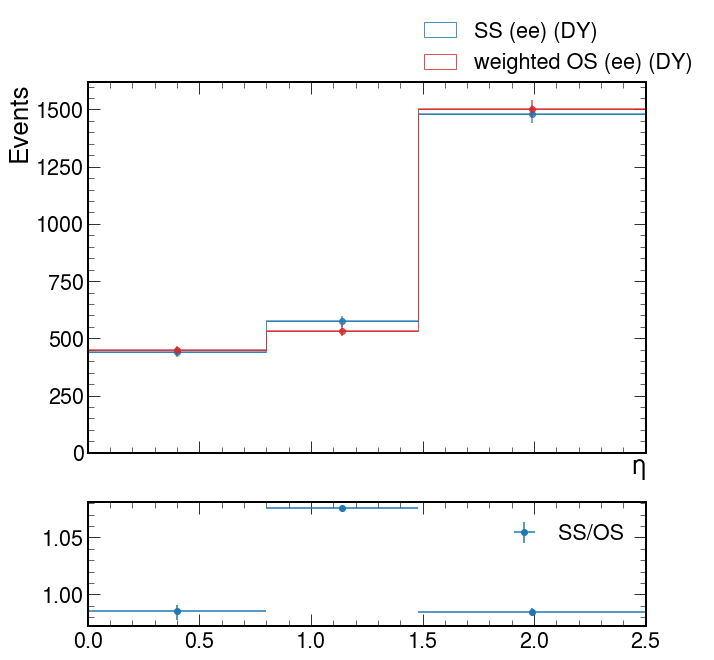

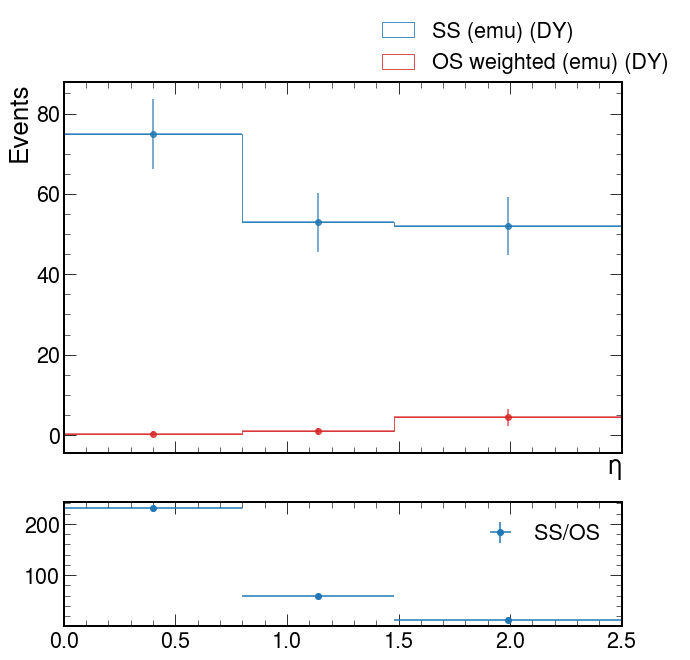

In [39]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C0")
h2_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C3")
h1_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True
)
h2_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True
)


fig.legend(["SS (ee) (ttbar)", "weighted OS (ee) (ttbar)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h1_TT.projection('y').divide(h2_TT.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C0")
h4_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C3")
h3_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True
)
h4_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True
)


fig.legend(["SS (emu) (ttbar)", "weighted OS (emu) (ttbar)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h3_TT.projection('y').divide(h4_TT.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C0")
h2_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C3")
h1_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True
)
h2_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True
)


fig.legend(["SS (ee) (DY)", "weighted OS (ee) (DY)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h1_DY.projection('y').divide(h2_DY.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C0")
h4_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C3")
h3_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C0", show_errors=True
)
h4_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C3", show_errors=True
)


fig.legend(["SS (emu) (DY)", "OS weighted (emu) (DY)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h3_DY.projection('y').divide(h4_DY.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


In [54]:
tmp1 = output['flipped_electron'].copy()
tmp1 = tmp1.rebin('pt', pt_bins)
tmp1 = tmp1.rebin('eta', eta_bins)


tmp2 = output['flipped_electron2'].copy()
tmp2 = tmp2.rebin('pt', pt_bins)
tmp2 = tmp2.rebin('eta', eta_bins)

tmp3 = output['flipped_electron3'].copy()
tmp3 = tmp3.rebin('pt', pt_bins)
tmp3 = tmp3.rebin('eta', eta_bins)

tmp4 = output['flipped_electron4'].copy()
tmp4 = tmp4.rebin('pt', pt_bins)
tmp4 = tmp4.rebin('eta', eta_bins)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)

h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

h3 = Hist2D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),
)

h4 = Hist2D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),
)

h1_TT = Hist2D.from_bincounts(
    tmp1.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),)

h2_TT = Hist2D.from_bincounts(
    tmp2.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),)

h3_TT = Hist2D.from_bincounts(
    tmp3.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),)

h4_TT = Hist2D.from_bincounts(
    tmp4.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),)

h1_DY = Hist2D.from_bincounts(
    tmp1.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),)

h2_DY = Hist2D.from_bincounts(
    tmp2.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),)

h3_DY = Hist2D.from_bincounts(
    tmp3.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),)

h4_DY = Hist2D.from_bincounts(
    tmp4.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),)

<AxesSubplot:>

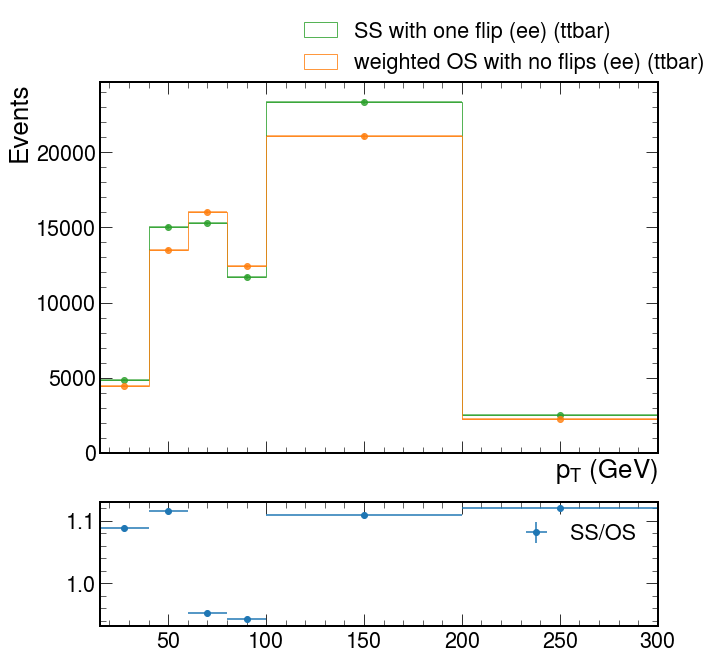

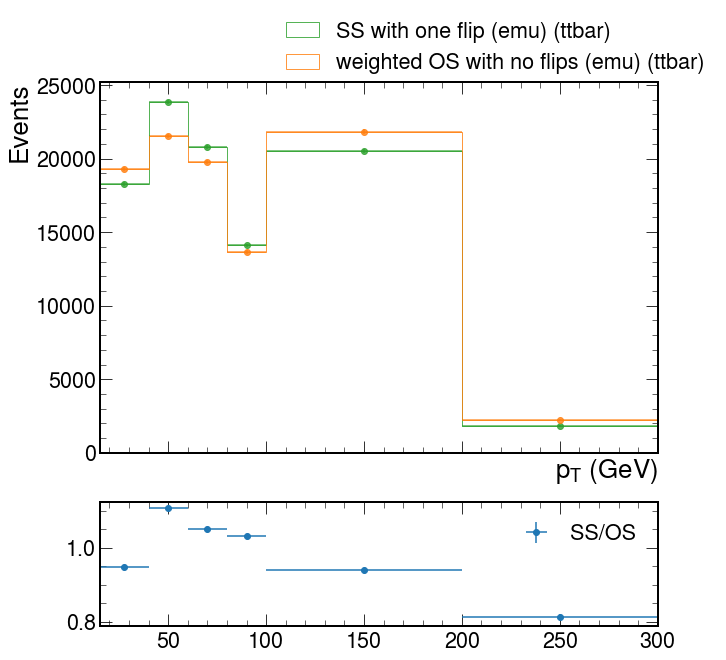

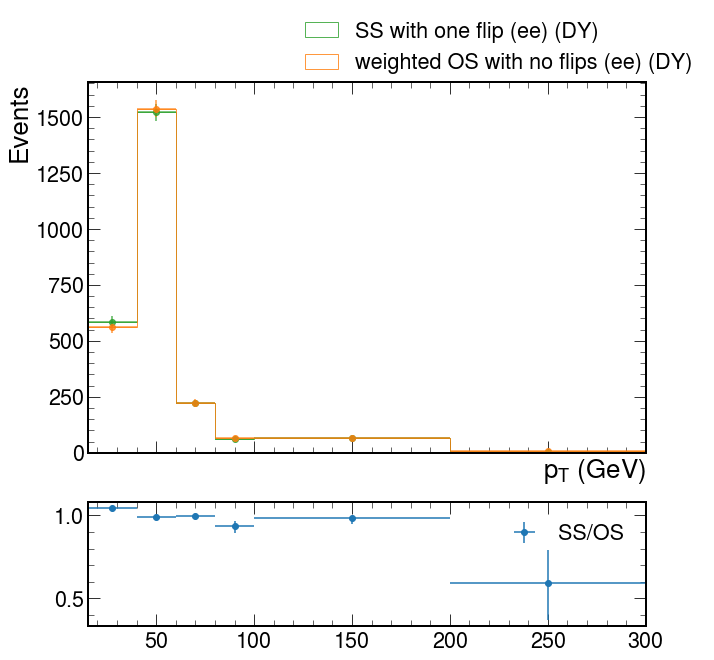

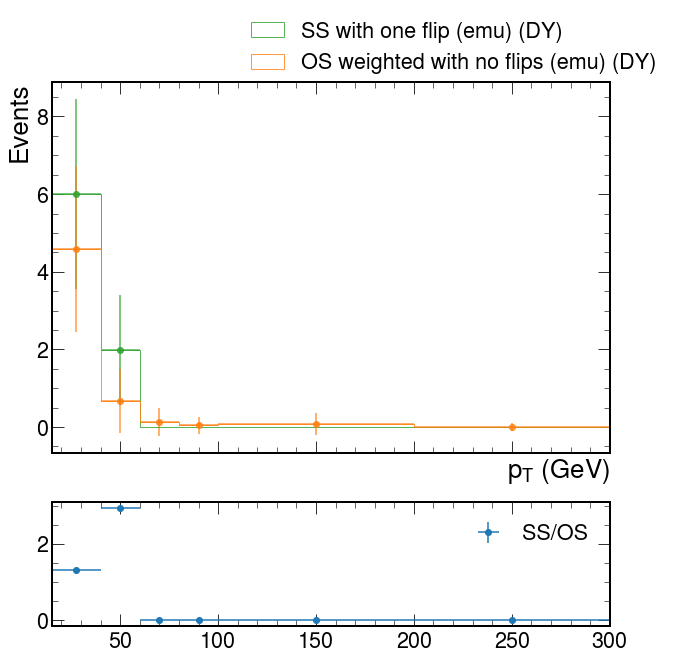

In [57]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C2")
h2_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C1")
h1_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h2_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (ee) (ttbar)", "weighted OS with no flips (ee) (ttbar)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h1_TT.projection('x').divide(h2_TT.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C2")
h4_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C1")
h3_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h4_TT.projection('x').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (emu) (ttbar)", "weighted OS with no flips (emu) (ttbar)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h3_TT.projection('x').divide(h4_TT.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C2")
h2_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C1")
h1_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h2_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (ee) (DY)", "weighted OS with no flips (ee) (DY)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h1_DY.projection('x').divide(h2_DY.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C2")
h4_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C1")
h3_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h4_DY.projection('x').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (emu) (DY)", "OS weighted with no flips (emu) (DY)"])

ax1.set_xlabel(r'$p_{T}\ (GeV) $')
ax1.set_ylabel(r'Events')

h3_DY.projection('x').divide(h4_DY.projection('x'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


<AxesSubplot:>

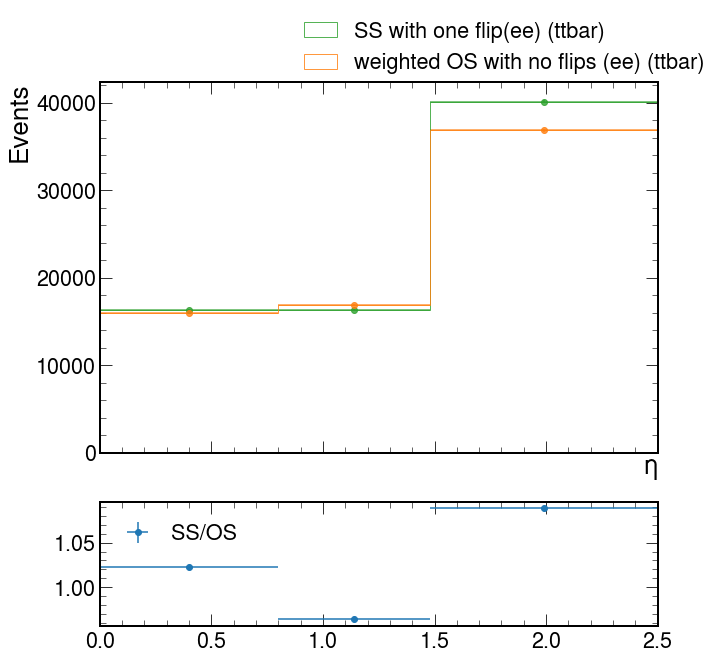

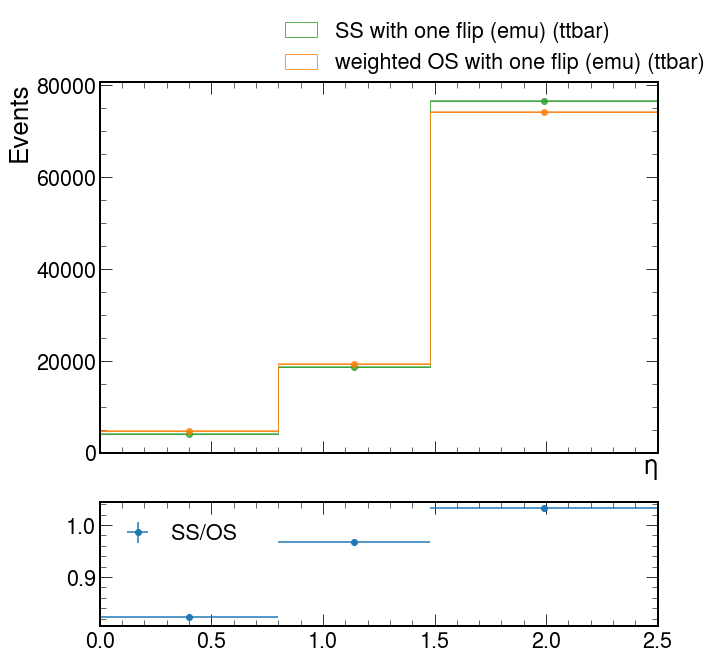

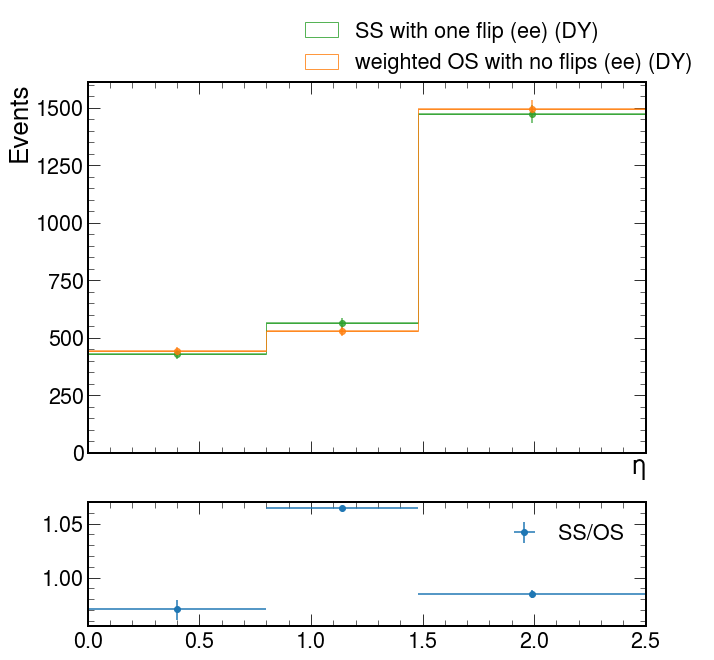

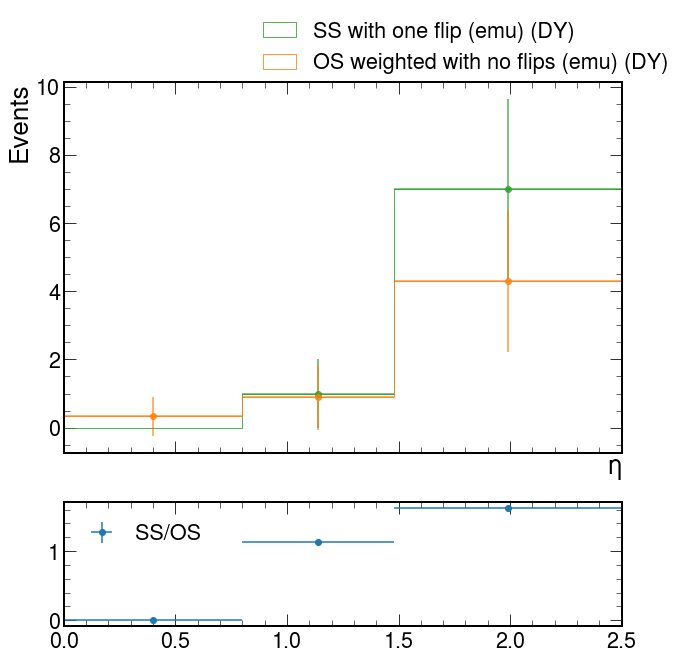

In [56]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C2")
h2_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C1")
h1_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h2_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip(ee) (ttbar)", "weighted OS with no flips (ee) (ttbar)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h1_TT.projection('y').divide(h2_TT.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C2")
h4_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C1")
h3_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h4_TT.projection('y').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (emu) (ttbar)", "weighted OS with one flip (emu) (ttbar)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h3_TT.projection('y').divide(h4_TT.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h1_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C2")
h2_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C1")
h1_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h2_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (ee) (DY)", "weighted OS with no flips (ee) (DY)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h1_DY.projection('y').divide(h2_DY.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(10,10), gridspec_kw=dict(height_ratios=[3, 1]))
h3_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C2")
h4_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C1")
h3_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C2", show_errors=True)
h4_DY.projection('y').plot(ax=ax1, alpha=0.8, color="C1", show_errors=True)


fig.legend(["SS with one flip (emu) (DY)", "OS weighted with no flips (emu) (DY)"])

ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'Events')

h3_DY.projection('y').divide(h4_DY.projection('y'), binomial=True).plot(ax=ax2, errors=True, label="SS/OS")


In [ ]:
print(h1.projection('x'))
print(h3.projection('x'))

In [ ]:
tmp1 = output['lepton_parent'].copy()
#tmp1 = tmp1.rebin('multiplicity', N_bins_red)


tmp2 = output['lepton_parent2'].copy()
#tmp2 = tmp2.rebin('multiplicity', N_bins_red)


h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pdgID').edges()),
)

h2 = Hist1D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp2.axis('pdgID').edges()),
)


fig, (ax1) = plt.subplots(1, figsize=(10,10))
h1.plot(ax=ax1, alpha=1, color="C3")
h2.plot(ax=ax1, alpha=1, color="C0")

ax1.set_yscale("log")
ax1.set_xlabel(r'$pdg\ ID\ (parent) $')
ax1.set_ylabel(r'Events')

fig.legend(["leading electron (SS)", "trailing electron (SS)"])


In [ ]:
tmp1 = output['N_jet'].copy()
tmp1 = tmp1.rebin('multiplicity', N_bins_red)



h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('multiplicity').edges()),
)


h1_TT = Hist1D.from_bincounts(
    tmp1.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('multiplicity').edges()),
)


h1_DY = Hist1D.from_bincounts(
    tmp1.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
    (tmp1.axis('multiplicity').edges()),
)


fig, (ax1) = plt.subplots(1, figsize=(10,10))
h1.plot(ax=ax1, alpha=1, color="C3")

ax1.set_yscale("log")
ax1.set_xlabel(r'$N_{lepton}\ $')
ax1.set_ylabel(r'Events')

fig.legend(["jets"])


fig, (ax1) = plt.subplots(1, figsize=(10,10))
h1_DY.plot(ax=ax1, alpha=1, color="C3")

ax1.set_yscale("log")
ax1.set_xlabel(r'$N_{lepton}\ $')
ax1.set_ylabel(r'Events')

fig.legend(["jets"])

fig, (ax1) = plt.subplots(1,  figsize=(10,10))
h1_TT.plot(ax=ax1, alpha=1, color="C3")

ax1.set_yscale("log")
ax1.set_xlabel(r'$N_{lepton}\ $')
ax1.set_ylabel(r'Events')

fig.legend(["jets"])


In [ ]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_ele'], meta, nano_mappings)


# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}\ $',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_comp'
        )


In [ ]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_jet'], samples, fileset, nano_mappings)


# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}\ $',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/ss/N_jet_ss'
        )


In [ ]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_ele2'], meta, nano_mappings)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}\ (ratio)$',
         new_colors=my_colors, new_labels=my_labels,
         omit=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_ratio'
        )


In [ ]:
my_hist = scale_and_merge(output['electron_flips'], meta, nano_mappings)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}\ (SS)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_flips_truth'
        )

In [ ]:
my_hist = scale_and_merge(output['electron_flips2'], meta, nano_mappings)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}\ (ratio)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['top'][0], nano_mappings['TTZ'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_flips_ratio'
        )

In [ ]:
my_hist = scale_and_merge(output['electron'], meta, nano_mappings)

makePlot(my_hist, None, 'pt',
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (flipped)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/pt_truth'
        )

In [ ]:
my_hist = scale_and_merge(output['electron2'], meta, nano_mappings)

makePlot(my_hist, None, 'pt',
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (weighted)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/pt_ratio'
        )

In [ ]:
my_hist = scale_and_merge(output['electron'], meta, nano_mappings)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)\ (flipped)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/eta_truth'
        )

In [ ]:
my_hist = scale_and_merge(output['electron2'], meta, nano_mappings)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)\ (weighted)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mappings['TTZ'][0], nano_mappings['top'][0], nano_mappings['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/eta_ratio'
        )

In [ ]:
from yahist import Hist1D, Hist2D
import numpy as np

In [ ]:
tmp1 = output['electron'].copy()
tmp1 = tmp1.rebin('eta', eta_bins)
tmp1 = tmp1.rebin('pt', pt_bins)


tmp2 = output['electron2'].copy()
tmp2 = tmp2.rebin('eta', eta_bins)
tmp2 = tmp2.rebin('pt', pt_bins)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)


h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

In [ ]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h1.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

In [ ]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h2.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')